In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from pydub import AudioSegment
from pydub.utils import mediainfo

import os
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\singh\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def mfcc_extraction(audio_filename, #.wav filename
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms)
                    num_mfcc, #number of mfcc features
                    num_frames #number of frames
                   ):
    speech = AudioSegment.from_wav(audio_filename) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    mfcc = librosa.feature.mfcc(
        np.float32(samples),
        sr = sampling_rate,
        hop_length = int(sampling_rate * hop_duration),
        n_mfcc = num_mfcc)
    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32)
    for i in range(min(num_frames, mfcc.shape[1])):
        mfcc_truncated[:, i] = mfcc[:, i]
    
    #output is a vector including mfcc_truncated.shape[0] * mfcc_truncated.shape[1] elements
    return np.reshape(mfcc_truncated.T, mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

In [3]:
sub_bands = [[300, 627], [628, 1060], [1061, 1633], [1634, 2393], [2394, 3400]]
n_freq = 16384 
n_mel_freq = 3401
win_duration = 0.030
hop_duration = 0.015
num_frames = 200
window = 'hann'

In [4]:
def SC_extraction(audio_filename):#250
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 2)
    
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range (min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = spec[:,i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        for f in range(num_frames):
            s = 0.000001
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                features[b][f] += k * spec_truncated[k][f]
                s += spec_truncated[k][f]
            features[b][f] /= s
            
    return np.reshape(features.T, features.shape[0] * features.shape[1])
    

In [5]:
def SBW_extraction(audio_filename):#251
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 2)
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        for f in range(num_frames):
            SC = 0
            s = 0.000001
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                SC += k * spec_truncated[k][f]
                s += spec_truncated[k][f]
            SC /= s
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                features[b][f] += (k - SC) * (k - SC) * spec_truncated[k][f]
            features[b][f] /= s
            
    return np.reshape(features.T, features.shape[0] * features.shape[1])

In [6]:
def SBE_extraction(audio_filename):#252 ~60% SVM (c=0.1)
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 2)
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        for f in range(num_frames):
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                features[b][f] += spec_truncated[k][f]
    
    for f in range(num_frames):
        s = np.sum(features[:,f]) + 0.000001
        features[:, f] /= s

    return np.reshape(features.T, features.shape[0] * features.shape[1])

In [7]:
def SFM_extraction(audio_filename):#253
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 2)
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        p = 1 / (sub_bands[b][1] - sub_bands[b][0] + 1)
        for f in range(num_frames):
            s = 0.000001
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                features[b][f] *= np.power(spec_truncated[k][f], p)
                s += spec_truncated[k][f]
            features[b][f] /= (p * s)

    return np.reshape(features.T, features.shape[0] * features.shape[1])

In [8]:
def SCF_extraction(audio_filename):#254
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 2)
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = spec[:, i]

    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        p = 1 / (sub_bands[b][1] - sub_bands[b][0] + 1)
        for f in range(num_frames):
            s = 0.000001
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                s += spec_truncated[k][f]
            features[b][f] = np.max(spec_truncated[sub_bands[b][0]:sub_bands[b][1] + 1][f]) / (p * s)
    return np.reshape(features.T, features.shape[0] * features.shape[1])

In [9]:
def RE_extraction(audio_filename, alpha = 3):#255
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 1)
    
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = abs(spec[:, i])
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        for f in range(num_frames):
            m = 0.000001 + np.sum(spec_truncated[sub_bands[b][0]:sub_bands[b][1] + 1][f])
            s = 0.000001
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                s += np.power(spec_truncated[k][f] / m, alpha)
            features[b][f] = 1 / (1 - alpha) * np.log2(s)
    return np.reshape(features.T, features.shape[0] * features.shape[1])

In [10]:
def SE_extraction(audio_filename):#255
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 1)
    
    spec_truncated = np.zeros((spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, spec.shape[1])):
        spec_truncated[:,i] = abs(spec[:, i])
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for b in range(len(sub_bands)):
        for f in range(num_frames):
            s = 0.000001 + np.sum(spec_truncated[sub_bands[b][0]:sub_bands[b][1] + 1][f])
            for k in range(sub_bands[b][0], sub_bands[b][1] + 1):
                ratio = 0.000001 + spec_truncated[k][f] / s
                features[b][f] -= ratio * np.log2(ratio)
                
    return np.reshape(features.T, features.shape[0] * features.shape[1])

In [32]:
path = "EmotionSpeech/"
emotions = ['Angry', 'Calm', 'Happy', 'Sad']

training_file_names = []
training_emotion_labels = []

for i in range(0, len(emotions)):
    sub_path = path + 'Train/' + emotions[i] + "/"
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_emotion_labels += sub_emotion_labels

test_file_names = []
test_emotion_labels = []
for i in range(0, len(emotions)):
    sub_path = path + 'Test/' + emotions[i] + "/"
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    test_file_names += sub_file_names
    test_emotion_labels += sub_emotion_labels

In [12]:
training_features_SC = []
training_features_SBW = []
training_features_SBE = []
training_features_SFM = []
training_features_SCF = []
training_features_RE = []
training_features_SE = []
count = 0

for filename in training_file_names:
    count += 1
    print (count, ":", len(training_file_names), ":", filename)
    features = SC_extraction(filename)
    training_features_SC.append(features)

    features = SBW_extraction(filename)
    training_features_SBW.append(features)

    features = SBE_extraction(filename)
    training_features_SBE.append(features)
    
    features = SFM_extraction(filename)
    training_features_SFM.append(features)
    
    features = SCF_extraction(filename)
    training_features_SCF.append(features)
    
    features = RE_extraction(filename)
    training_features_RE.append(features)

    features = SE_extraction(filename)
    training_features_SE.append(features)
    
    
with open('sc_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_SC, fs)

with open('sbw_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_SBW, fs)

with open('sbe_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_SBE, fs)
    
with open('sfm_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_SFM, fs)
    
with open('scf_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_SCF, fs)
    
with open('re_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_RE, fs)
    
with open('se_mel_train.spc', 'wb') as fs:
    pickle.dump(training_features_SE, fs)
    

1 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


2 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-01-02.wav
3 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


4 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-01-04.wav
5 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-02-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


6 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-02-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


7 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


8 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-02-04.wav
9 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


10 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-01-02.wav
11 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 5. 7.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


12 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-01-04.wav
13 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-02-01.wav
14 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-02-02.wav
15 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  -3.   -3.   -2. ... -199. -199. -199.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


16 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-02-02-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


17 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-27. -17. -18. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


18 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-01-02.wav
19 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-7. -9.  4. ... -5. -5. -7.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


20 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-01-04.wav
21 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-02-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-22.  83. 104. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


22 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-02-02.wav
23 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 22.  19.  15. ... -59. -74. -48.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


24 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-02-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


25 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[14. 20. 44. ... -8. -9.  2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


26 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-01-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


27 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[3. 0. 6. ... 6. 3. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


28 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-01-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


29 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-02-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[12. 11.  9. ... 17. 19. 25.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


30 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-02-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


31 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  1.  1. ... 24. 25. 36.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


32 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-02-04.wav
33 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-01-01.wav
34 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-01-02.wav
35 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


36 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-01-04.wav
37 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-02-01.wav
38 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-02-02.wav
39 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -3. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


40 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-01-02-04.wav
41 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-01-01.wav
42 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-01-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


43 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-01-03.wav
44 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-01-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 3. 1. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


45 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-02-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 1. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


46 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-02-02.wav
47 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 4. 4. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


48 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-02-04.wav
49 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0. -1. ... -1. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


50 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-01-02.wav
51 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ...  0.  0. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


52 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-01-04.wav
53 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-02-01.wav
54 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-02-02.wav
55 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ...  0.  0. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


56 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-01-02-04.wav
57 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 1.  1.  1. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


58 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-01-02.wav
59 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0. -1. -1. ... -7. -8. -8.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


60 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-01-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -1.  0. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


61 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-02-01.wav
62 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-02-02.wav
63 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[2. 0. 1. ... 7. 6. 5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


64 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-02-04.wav
65 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-01-01.wav
66 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-01-02.wav
67 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 3. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


68 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-01-04.wav
69 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-02-01.wav
70 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-02-02.wav
71 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[15. 22.  2. ... -1. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


72 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-01-02-04.wav
73 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-01-01.wav
74 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-01-02.wav
75 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 2. 2. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


76 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-01-04.wav
77 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-02-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 1. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


78 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-02-02.wav
79 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-02-03.wav
80 : 128 : EmotionSpeech/Train/Happy/03-01-03-01-02-02-04.wav
81 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-01-01.wav
82 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-01-02.wav
83 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


84 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-01-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


85 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-02-01.wav
86 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-02-02.wav
87 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[7. 5. 2. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


88 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-02-04.wav
89 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-01-01.wav
90 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-01-02.wav
91 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-9. -8. -9. ... -6. -8. -6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


92 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-01-04.wav
93 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-02-01.wav
94 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-02-02.wav
95 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 23.  -5. -33. ...  11.  12.  12.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


96 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-02-04.wav
97 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-01-01.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-1.  0.  0. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


98 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-01-02.wav
99 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -5. -6. -4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


100 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-01-04.wav
101 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-02-01.wav
102 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-02-02.wav
103 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 2. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


104 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-01-02-04.wav
105 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-01-01.wav
106 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-01-02.wav
107 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  0.   0.   0. ... -12. -11. -11.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


108 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-01-04.wav
109 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-02-01.wav
110 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-02-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


111 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-1.  0. -1. ...  8.  8.  8.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


112 : 128 : EmotionSpeech/Train/Sad/03-01-04-01-02-02-04.wav
113 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-01-01.wav
114 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-01-02.wav
115 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 1.  0.  1. ... -2.  0. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


116 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-01-04.wav
117 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-02-01.wav
118 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-02-02.wav
119 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


120 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-01-02-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


121 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-01-01.wav
122 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-01-02.wav
123 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


124 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-01-04.wav
125 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-02-01.wav
126 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-02-02.wav
127 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


128 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-02-04.wav


In [13]:
test_features_SC = []
test_features_SBW = []
test_features_SBE = []
test_features_SFM = []
test_features_SCF = []
test_features_RE = []
test_features_SE = []
count = 0

for filename in test_file_names:
    count += 1
    print (count, ":", len(test_file_names), ":", filename)
    features = SC_extraction(filename)
    test_features_SC.append(features)

    features = SBW_extraction(filename)
    test_features_SBW.append(features)

    features = SBE_extraction(filename)
    test_features_SBE.append(features)
    
    features = SFM_extraction(filename)
    test_features_SFM.append(features)
    
    features = SCF_extraction(filename)
    test_features_SCF.append(features)
    
    features = RE_extraction(filename)
    test_features_RE.append(features)

    features = SE_extraction(filename)
    test_features_SE.append(features)
    
    
with open('sc_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_SC, fs)

with open('sbw_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_SBW, fs)

with open('sbe_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_SBE, fs)
    
with open('sfm_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_SFM, fs)
    
with open('scf_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_SCF, fs)
    
with open('re_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_RE, fs)
    
with open('se_mel_test.spc', 'wb') as fs:
    pickle.dump(test_features_SE, fs)

1 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2. -2. -1. ... -1. -1. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


2 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


3 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


4 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


5 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-02-05.wav
6 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


7 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


8 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  0.   0.  -1. ... -86. -71. -78.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


9 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 1. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


10 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ...  0.  0. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


11 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-01-07.wav
12 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-3. -3. -3. ...  6.  7.  6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


13 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-1.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


14 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-02-06.wav
15 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-02-07.wav
16 : 128 : EmotionSpeech/Test/Angry/03-01-05-01-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-6. -6. -7. ...  7.  7.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


17 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[2. 1. 1. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


18 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


19 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-20. -21. -20. ...  76.  75.  74.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


20 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 6.  6.  5. ... -5. -5. -6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


21 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-3. -2. -2. ... 13. 14. 14.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


22 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[35. 27. 18. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


23 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  4.   4.   4. ... -69. -66. -66.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


24 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


25 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ...  0. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


26 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0. -1.  0. ...  0. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


27 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2. -2. -2. ...  0.  1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


28 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[5. 3. 4. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


29 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 1. 1. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


30 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[6. 2. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


31 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  1.   1.   1. ... -12. -10. -10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


32 : 128 : EmotionSpeech/Test/Angry/03-01-05-02-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[6. 5. 7. ... 1. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


33 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -1. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


34 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 1. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


35 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-01-07.wav
36 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 2. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


37 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-02-05.wav
38 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 0. 0. ... 2. 3. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


39 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-02-07.wav
40 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 3. 4. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


41 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[2. 2. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


42 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 1. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


43 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 3.  3.  2. ... -4. -4. -4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


44 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-7. -6. -6. ...  1.  1.  2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


45 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 1.  1.  0. ... -2. -2. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


46 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2.  0.  0. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


47 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-02-07.wav
48 : 128 : EmotionSpeech/Test/Calm/03-01-02-01-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[4. 5. 4. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


49 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-01-05.wav
50 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  1. ... -5. -6. -4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


51 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 12.  11.   0. ... -35. -36. -36.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


52 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-01-08.wav
53 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-02-05.wav
54 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0. -1. -1. ... -1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


55 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


56 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-3. -3. -3. ... -2. -2. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


57 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-1. -1. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


58 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-01-06.wav
59 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -1.  0. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


60 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-5. -5. -5. ... -3. -3. -3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


61 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-02-05.wav
62 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-02-06.wav
63 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[2. 2. 3. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


64 : 128 : EmotionSpeech/Test/Calm/03-01-02-02-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


65 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-01-05.wav
66 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-01-06.wav
67 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-01-07.wav
68 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


69 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


70 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-02-06.wav
71 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


72 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-01-02-08.wav
73 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-01-05.wav
74 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-01-06.wav
75 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2. -2. -1. ... 10. 10. 10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


76 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 1.  2.  2. ... -5. -4. -5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


77 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-02-05.wav
78 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 2.  2.  1. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


79 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-02-07.wav
80 : 128 : EmotionSpeech/Test/Happy/03-01-03-01-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


81 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-01-05.wav
82 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0. -1. ...  5.  7.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


83 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 1.  0. -1. ...  2.  2.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


84 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-3. -3. -2. ...  0. -2. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


85 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 3. 3. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


86 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-02-06.wav
87 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0. 13. 21. ...  1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


88 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 2.  2.  2. ... -1. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


89 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-5. -5. -5. ...  1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


90 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-01-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-1.  0.  0. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


91 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ -2.  -2.  -1. ... -15. -14. -13.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


92 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  3.   3.   2. ... -12. -12. -12.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


93 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0. -2. -2. ...  2.  1.  2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


94 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 1.  1.  2. ... 21. 17. 18.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


95 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 2. 7. ... 6. 5. 5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


96 : 128 : EmotionSpeech/Test/Happy/03-01-03-02-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-2. -1. -2. ... -4. -4. -5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


97 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 0. 0. ... 2. 1. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


98 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-01-06.wav
99 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-01-07.wav
100 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[7. 8. 9. ... 3. 3. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


101 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-02-05.wav
102 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-02-06.wav
103 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-02-07.wav
104 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


105 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-01-05.wav
106 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-01-06.wav
107 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


108 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... -3. -4. -3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


109 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-02-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[2. 3. 2. ... 0. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


110 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-02-06.wav
111 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 2. 1. ... 1. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


112 : 128 : EmotionSpeech/Test/Sad/03-01-04-01-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[4. 4. 5. ... 6. 6. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


113 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-1. -1. -1. ... -1. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


114 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-01-06.wav
115 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0. -3. ...  0. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


116 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 7.  6.  7. ...  0. -2. -4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


117 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-02-05.wav
118 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 8.  8.  7. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


119 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-02-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[-3. -3. -1. ... 35. 37. 34.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


120 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-01-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... 25. 26. 26.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


121 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-01-05.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[19. 18. 19. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


122 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-01-06.wav
123 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-01-07.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[  10.   17.   12. ... -126. -127. -129.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


124 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-01-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[0. 0. 0. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


125 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-02-05.wav
126 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-02-06.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[1. 0. 1. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


127 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-02-07.wav
128 : 128 : EmotionSpeech/Test/Sad/03-01-04-02-02-02-08.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_7852\3620632353.py:6: FutureWarning: Pass y=[ 0.  0.  0. ... 76. 75. 73.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


In [12]:
svm_classifier = svm.SVC(C=0.1, kernel = 'linear')

#spectral_features_list = ['sc_mel', 'sbw_mel', 'sbe_mel', 'sfm_mel', 'scf_mel', 're_mel', 'se_mel'] #scf_mel hangs for some reason
spectral_features_list = ['sc_mel', 'sbw_mel', 'sbe_mel', 'sfm_mel', 're_mel', 'se_mel']

print("############################################################")
for spectral_feature in spectral_features_list:
    training_features, test_features = None, None
    train_name = spectral_feature + "_train.spc"
    test_name = spectral_feature + "_test.spc"
    print("Testing spectral feature:", spectral_feature)
    with open(train_name, 'rb') as f:
        training_features = pickle.load(f)
    with open(test_name, 'rb') as f:
        test_features = pickle.load(f)
        
    svm_classifier.fit(training_features, training_emotion_labels)
    
    predicted_emotion_labels = svm_classifier.predict(test_features)
    print("SVM accuracy for spectral feature:", spectral_feature, " is: ", 
          np.sum(predicted_emotion_labels == test_emotion_labels)/ len(test_emotion_labels))
    cm = confusion_matrix(test_emotion_labels, predicted_emotion_labels)
    print("SVM confusion matrix\n ", cm)
    print("############################################################")


############################################################
Testing spectral feature: sc_mel
SVM accuracy for spectral feature: sc_mel  is:  0.4140625
SVM confusion matrix
  [[18  5  3  6]
 [ 6 16  5  5]
 [ 4  6 13  9]
 [ 6  7 13  6]]
############################################################
Testing spectral feature: sbw_mel
SVM accuracy for spectral feature: sbw_mel  is:  0.4921875
SVM confusion matrix
  [[15  3  7  7]
 [ 3 17  3  9]
 [ 7 11 12  2]
 [ 4  6  3 19]]
############################################################
Testing spectral feature: sbe_mel
SVM accuracy for spectral feature: sbe_mel  is:  0.5859375
SVM confusion matrix
  [[25  5  2  0]
 [ 6 24  1  1]
 [ 8  9 15  0]
 [ 7  5  9 11]]
############################################################
Testing spectral feature: sfm_mel
SVM accuracy for spectral feature: sfm_mel  is:  0.25
SVM confusion matrix
  [[ 0  0  0 32]
 [ 0  0  0 32]
 [ 0  0  0 32]
 [ 0  0  0 32]]
#######################################################

#### 3. Speech emotion recognition using deep learning|

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import time

In [14]:
import numpy as np
import cv2 as cv

# this method is used to normalise X into [0, 255]
def scale(X):
    X_min = X.min()
    X_max = X.max()
    X_scaled = (X - X_min) / (X_max - X_min) * 255
    X_scaled = X_scaled.astype(np.uint8)
    return X_scaled

# this method saves X into image file.
def spectrogram2image(X, filename):
    X_scaled = scale(X)
    cv.imwrite(filename, X_scaled)

#### Save spectrogram images to folder

In [38]:
basepath = "C:\\Users\\singh\\Documents\\MastersAppliedAIDeakin\\SIT789_CompVision_SpeechProcessing\\Practicals\\"
savepath_train = basepath + "spectrogram_train_images\\"
savepath_test = basepath + "spectrogram_test_images\\"

for filename in training_file_names:
    speech = AudioSegment.from_wav(filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 1)
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    
    file_basename = os.path.basename(filename)
    if "Angry" in filename:
        filename_jpg = "Angry\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
    if "Calm" in filename:
        filename_jpg = "Calm\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
    if "Happy" in filename:
        filename_jpg = "Happy\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
    if "Sad" in filename:
        filename_jpg = "Sad\\" + file_basename[:file_basename.rfind(".")] + ".jpg"

    print(filename_jpg)
    spectrogram2image(spec_db, savepath_train + filename_jpg)
    
for filename in test_file_names:
    speech = AudioSegment.from_wav(filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                         hop_length = int(sampling_rate * hop_duration),
                                         n_fft = n_freq,
                                         n_mels = n_mel_freq,
                                         power = 1)
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)

    file_basename = os.path.basename(filename)
    if "Angry" in filename:
        filename_jpg = "Angry\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
    if "Calm" in filename:
        filename_jpg = "Calm\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
    if "Happy" in filename:
        filename_jpg = "Happy\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
    if "Sad" in filename:
        filename_jpg = "Sad\\" + file_basename[:file_basename.rfind(".")] + ".jpg"
        
    spectrogram2image(spec_db, savepath_test + filename_jpg)

C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-01-01-01.jpg
Angry\03-01-05-01-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-01-01-03.jpg
Angry\03-01-05-01-01-01-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-01-02-01.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-01-02-03.jpg
Angry\03-01-05-01-01-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-02-01-01.jpg
Angry\03-01-05-01-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 5. 7.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-02-01-03.jpg
Angry\03-01-05-01-02-01-04.jpg
Angry\03-01-05-01-02-02-01.jpg
Angry\03-01-05-01-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[  -3.   -3.   -2. ... -199. -199. -199.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-02-02-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-01-02-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-27. -17. -18. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-01-01-01.jpg
Angry\03-01-05-02-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-7. -9.  4. ... -5. -5. -7.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-01-01-03.jpg
Angry\03-01-05-02-01-01-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-22.  83. 104. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-01-02-01.jpg
Angry\03-01-05-02-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 22.  19.  15. ... -59. -74. -48.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-01-02-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-01-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[14. 20. 44. ... -8. -9.  2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-01-01.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[3. 0. 6. ... 6. 3. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-01-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-01-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[12. 11.  9. ... 17. 19. 25.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-02-01.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  1.  1. ... 24. 25. 36.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Angry\03-01-05-02-02-02-03.jpg
Angry\03-01-05-02-02-02-04.jpg
Calm\03-01-02-01-01-01-01.jpg
Calm\03-01-02-01-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-01-01-01-03.jpg
Calm\03-01-02-01-01-01-04.jpg
Calm\03-01-02-01-01-02-01.jpg
Calm\03-01-02-01-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -3. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-01-01-02-03.jpg
Calm\03-01-02-01-01-02-04.jpg
Calm\03-01-02-01-02-01-01.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-01-02-01-02.jpg
Calm\03-01-02-01-02-01-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 1. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-01-02-01-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 1. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-01-02-02-01.jpg
Calm\03-01-02-01-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 4. 4. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-01-02-02-03.jpg
Calm\03-01-02-01-02-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0. -1. ... -1. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-01-01-01.jpg
Calm\03-01-02-02-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ...  0.  0. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-01-01-03.jpg
Calm\03-01-02-02-01-01-04.jpg
Calm\03-01-02-02-01-02-01.jpg
Calm\03-01-02-02-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ...  0.  0. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-01-02-03.jpg
Calm\03-01-02-02-01-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 1.  1.  1. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-02-01-01.jpg
Calm\03-01-02-02-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0. -1. -1. ... -7. -8. -8.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-02-01-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -1.  0. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-02-01-04.jpg
Calm\03-01-02-02-02-02-01.jpg
Calm\03-01-02-02-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[2. 0. 1. ... 7. 6. 5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Calm\03-01-02-02-02-02-03.jpg
Calm\03-01-02-02-02-02-04.jpg
Happy\03-01-03-01-01-01-01.jpg
Happy\03-01-03-01-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[1. 3. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-01-01-01-03.jpg
Happy\03-01-03-01-01-01-04.jpg
Happy\03-01-03-01-01-02-01.jpg
Happy\03-01-03-01-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[15. 22.  2. ... -1. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-01-01-02-03.jpg
Happy\03-01-03-01-01-02-04.jpg
Happy\03-01-03-01-02-01-01.jpg
Happy\03-01-03-01-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 2. 2. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-01-02-01-03.jpg
Happy\03-01-03-01-02-01-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 1. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-01-02-02-01.jpg
Happy\03-01-03-01-02-02-02.jpg
Happy\03-01-03-01-02-02-03.jpg
Happy\03-01-03-01-02-02-04.jpg
Happy\03-01-03-02-01-01-01.jpg
Happy\03-01-03-02-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-02-01-01-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ...  0. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-02-01-01-04.jpg
Happy\03-01-03-02-01-02-01.jpg
Happy\03-01-03-02-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[7. 5. 2. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-02-01-02-03.jpg
Happy\03-01-03-02-01-02-04.jpg
Happy\03-01-03-02-02-01-01.jpg
Happy\03-01-03-02-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-9. -8. -9. ... -6. -8. -6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-02-02-01-03.jpg
Happy\03-01-03-02-02-01-04.jpg
Happy\03-01-03-02-02-02-01.jpg
Happy\03-01-03-02-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 23.  -5. -33. ...  11.  12.  12.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Happy\03-01-03-02-02-02-03.jpg
Happy\03-01-03-02-02-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-1.  0.  0. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-01-01-01-01.jpg
Sad\03-01-04-01-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -5. -6. -4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-01-01-01-03.jpg
Sad\03-01-04-01-01-01-04.jpg
Sad\03-01-04-01-01-02-01.jpg
Sad\03-01-04-01-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 2. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-01-01-02-03.jpg
Sad\03-01-04-01-01-02-04.jpg
Sad\03-01-04-01-02-01-01.jpg
Sad\03-01-04-01-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[  0.   0.   0. ... -12. -11. -11.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-01-02-01-03.jpg
Sad\03-01-04-01-02-01-04.jpg
Sad\03-01-04-01-02-02-01.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-01-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-1.  0. -1. ...  8.  8.  8.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-01-02-02-03.jpg
Sad\03-01-04-01-02-02-04.jpg
Sad\03-01-04-02-01-01-01.jpg
Sad\03-01-04-02-01-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 1.  0.  1. ... -2.  0. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-02-01-01-03.jpg
Sad\03-01-04-02-01-01-04.jpg
Sad\03-01-04-02-01-02-01.jpg
Sad\03-01-04-02-01-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-02-01-02-03.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-02-01-02-04.jpg
Sad\03-01-04-02-02-01-01.jpg
Sad\03-01-04-02-02-01-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-02-02-01-03.jpg
Sad\03-01-04-02-02-01-04.jpg
Sad\03-01-04-02-02-02-01.jpg
Sad\03-01-04-02-02-02-02.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


Sad\03-01-04-02-02-02-03.jpg
Sad\03-01-04-02-02-02-04.jpg


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[-2. -2. -1. ... -1. -1. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing the

C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[1. 2. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[1. 0. 0. ... 2. 3. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[0. 0. 0. ... 3. 4. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[2. 2. 2. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional argumen

C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[0. 0. 0. ... 3. 3. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[ 0. 13. 21. ...  1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[ 2.  2.  2. ... -1. -1.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),
C:\Users\singh\AppData\Local\Temp\ipykernel_14356\4136644315.py:33: FutureWarning: Pass y=[-5. -5. -5. ...  1.  0.  0.] as keyword args. From version 0.10 passing these as 

In [39]:
transform = transforms.Compose(
    [transforms.Resize((150, 50)),
     transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = datasets.ImageFolder(savepath_train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=8, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(savepath_test, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)
classes = ('Angry', 'Calm', 'Happy', 'Sad')

In [40]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print (labels)

tensor([3, 3, 1, 2, 0, 0, 3, 3])
tensor([0, 0, 3, 0, 3, 0, 1, 0])
tensor([0, 1, 3, 1, 1, 0, 2, 0])
tensor([3, 1, 2, 0, 2, 3, 2, 2])
tensor([1, 3, 3, 3, 2, 3, 3, 2])
tensor([2, 1, 0, 3, 0, 3, 3, 2])
tensor([1, 1, 1, 1, 3, 2, 1, 1])
tensor([3, 2, 3, 2, 3, 0, 2, 1])
tensor([0, 1, 1, 3, 0, 0, 1, 1])
tensor([0, 0, 1, 2, 2, 2, 0, 2])
tensor([2, 1, 0, 3, 0, 1, 0, 2])
tensor([2, 0, 3, 1, 3, 0, 0, 0])
tensor([0, 1, 3, 2, 1, 3, 3, 1])
tensor([2, 3, 0, 2, 3, 2, 1, 0])
tensor([1, 3, 2, 2, 2, 1, 1, 2])
tensor([1, 2, 3, 0, 1, 2, 0, 2])


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9 * 34 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x)
        x = x.view(-1, 9 * 34 * 10) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
print (net)

Net(
  (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3060, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


cuda:0
[1,    10] loss: 0.007
[2,    10] loss: 0.007
[3,    10] loss: 0.007
[4,    10] loss: 0.007
[5,    10] loss: 0.007
[6,    10] loss: 0.007
[7,    10] loss: 0.006
[8,    10] loss: 0.007
[9,    10] loss: 0.006
[10,    10] loss: 0.005
[11,    10] loss: 0.006
[12,    10] loss: 0.005
[13,    10] loss: 0.006
[14,    10] loss: 0.005
[15,    10] loss: 0.004
[16,    10] loss: 0.004
[17,    10] loss: 0.002
[18,    10] loss: 0.002
[19,    10] loss: 0.004
[20,    10] loss: 0.003
[21,    10] loss: 0.002
[22,    10] loss: 0.003
[23,    10] loss: 0.002
[24,    10] loss: 0.001
[25,    10] loss: 0.002
[26,    10] loss: 0.001
[27,    10] loss: 0.001
[28,    10] loss: 0.001
[29,    10] loss: 0.000
[30,    10] loss: 0.001
[31,    10] loss: 0.001
[32,    10] loss: 0.001
[33,    10] loss: 0.002
[34,    10] loss: 0.000
[35,    10] loss: 0.000
[36,    10] loss: 0.001
[37,    10] loss: 0.002
[38,    10] loss: 0.001
[39,    10] loss: 0.000
[40,    10] loss: 0.000
[41,    10] loss: 0.000
[42,    10] loss: 

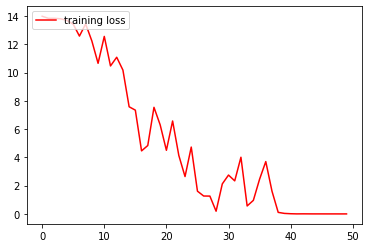

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
net = net.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_history = []
epoch = 50

start = time.time()
for e in range(epoch): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
            
time1 = time.time() - start
print('Finished GPU Training in time:(avg time per epoch) ', time1/epoch)
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [43]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

predicted_labels_entire = []
groundtruth_labels_entire = []

start = time.time()
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        
        groundtruth_labels_entire += groundtruth_labels.cpu()
        
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
           
        predicted_labels_entire += predicted_labels.cpu()

        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(4):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

time1 = time.time() - start
print('Finished GPU Testing in time: ', time1)

for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
print ("Confusion matrix: \n", cm)

Finished GPU Testing in time:  1.6055960655212402
Accuracy of Angry : 68 %
Accuracy of  Calm : 56 %
Accuracy of Happy : 37 %
Accuracy of   Sad : 40 %
Confusion matrix: 
 [[22  1  6  3]
 [ 4 18  1  9]
 [ 4  7 12  9]
 [ 7  1 11 13]]


In [47]:
print(classification_report(groundtruth_labels_entire, predicted_labels_entire))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64        32
           1       0.67      0.56      0.61        32
           2       0.40      0.38      0.39        32
           3       0.38      0.41      0.39        32

    accuracy                           0.51       128
   macro avg       0.51      0.51      0.51       128
weighted avg       0.51      0.51      0.51       128



0 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[ 23.  -5. -33. ...  11.  12.  12.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


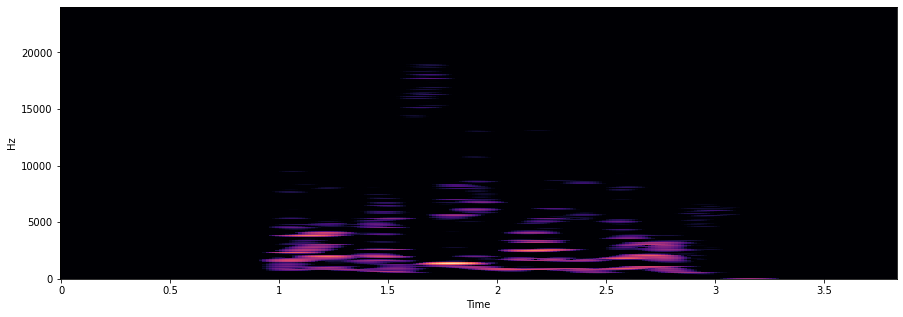

1 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-02-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


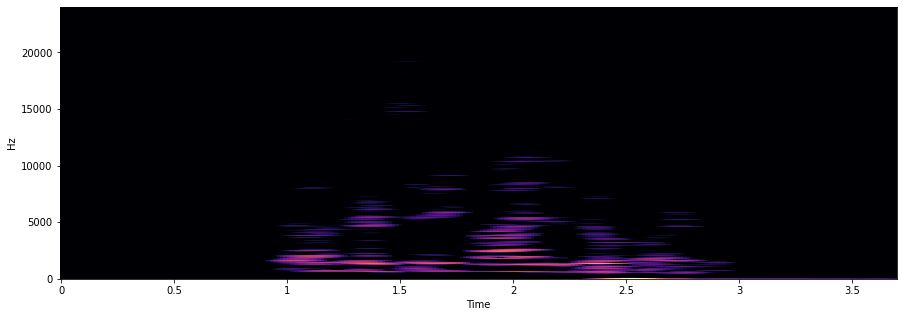

2 : 128 : EmotionSpeech/Train/Sad/03-01-04-02-02-01-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


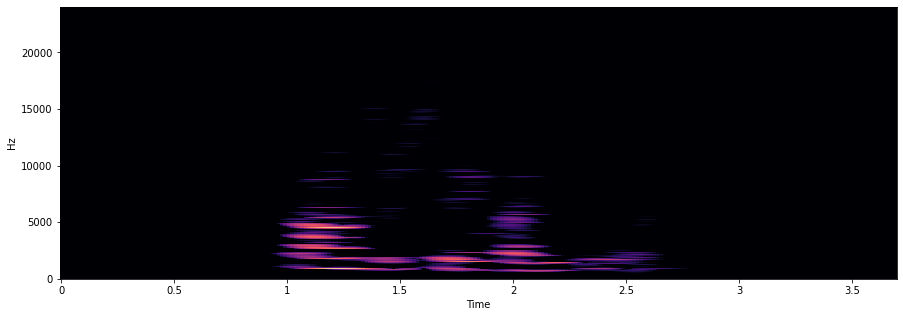

3 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-02-02-02.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


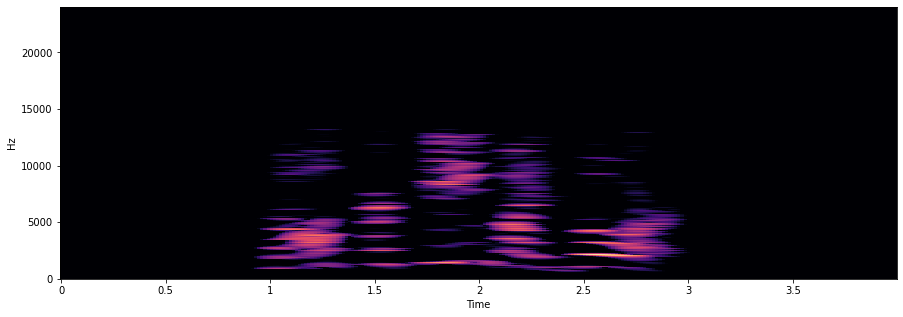

4 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-01-03.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[-7. -9.  4. ... -5. -5. -7.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


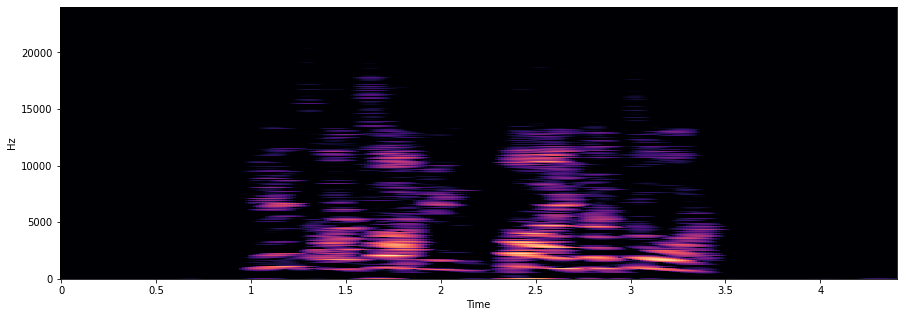

5 : 128 : EmotionSpeech/Train/Calm/03-01-02-01-02-02-04.wav


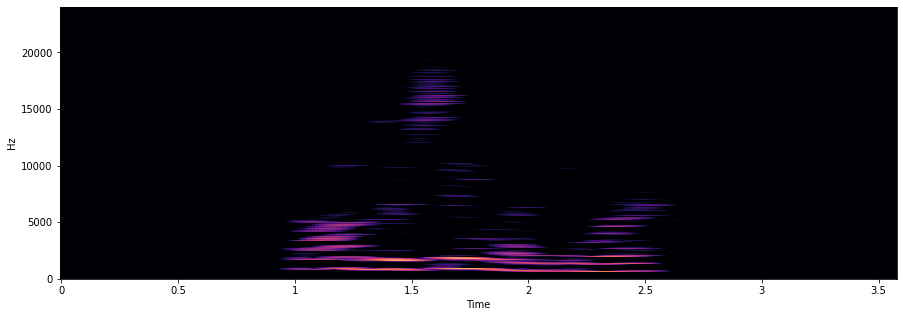

6 : 128 : EmotionSpeech/Train/Angry/03-01-05-02-01-02-04.wav


C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[0. 0. 0. ... 1. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


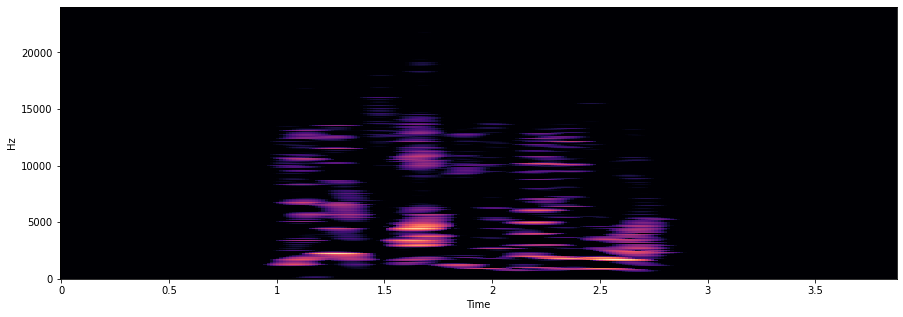

7 : 128 : EmotionSpeech/Train/Happy/03-01-03-02-01-02-01.wav


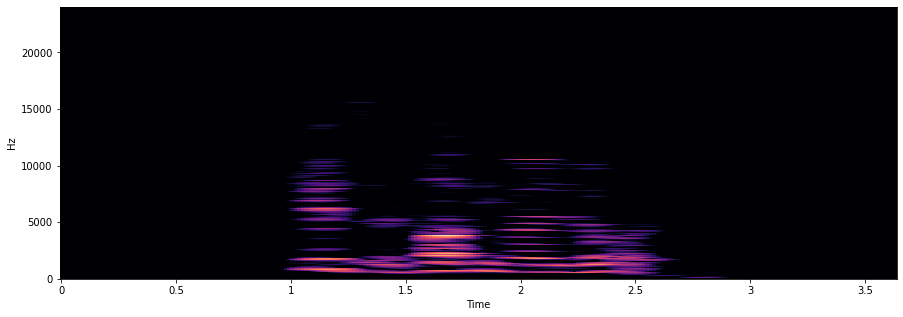

C:\Users\singh\AppData\Local\Temp\ipykernel_14356\2879885147.py:10: FutureWarning: Pass y=[ 0.  0.  0. ... -1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(np.float32(samples),


8 : 128 : EmotionSpeech/Train/Angry/03-01-05-01-01-02-03.wav


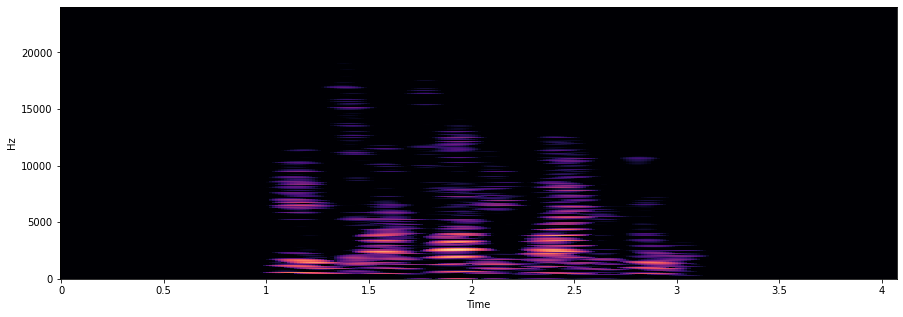

9 : 128 : EmotionSpeech/Train/Calm/03-01-02-02-02-02-02.wav


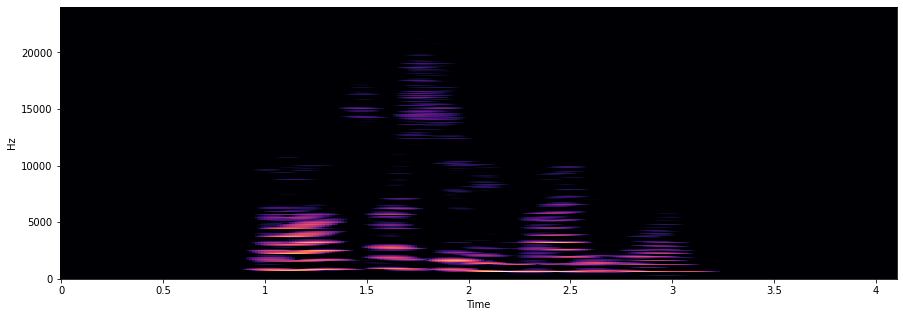

In [45]:
#display 10 random spectograms
import random
count = 0
for filename in random.sample(training_file_names, 10):
    print (count, ":", len(training_file_names), ":", filename)
    speech = AudioSegment.from_wav(filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate
    count += 1
    spec = librosa.feature.melspectrogram(np.float32(samples),
                                             hop_length = int(sampling_rate * hop_duration),
                                             n_fft = n_freq,
                                             n_mels = n_mel_freq,
                                             power = 2)
    plt.figure(figsize = (15, 5))
    #convert the amplitude to decibels, just for illustration purpose
    Xdb = librosa.amplitude_to_db(abs(spec))
    librosa.display.specshow(
        #spectrogram
        Xdb,
        #sampling rate
        sr = sampling_rate,
        #label for horizontal axis
        x_axis = 'time',
        #presentation scale
        y_axis = 'linear',
        #hop_length
        hop_length = int(sampling_rate * hop_duration))
    plt.show()